In [18]:
import deepqmc
import haiku as hk
import jax

In [19]:
from deepqmc.molecule import Molecule

mol = Molecule(  # LiH
    coords=[[0.0, 0.0, 0.0], [3.015, 0.0, 0.0]],
    charges=[3, 1],
    charge=0,
    spin=0,
    unit='bohr',
)

In [20]:
from deepqmc.hamil import MolecularHamiltonian

H = MolecularHamiltonian(mol=mol)

In [21]:
from deepqmc.wf.nn_wave_function import eval_log_slater, Psi
from deepqmc.wf.env import ExponentialEnvelopes
from deepqmc.app import instantiate_ansatz

class MyWF(hk.Module):
    def __init__(
        self,
        hamil,
    ):
        super().__init__()
        self.mol = hamil.mol
        self.n_up, self.n_down = hamil.n_up, hamil.n_down
        self.charges = hamil.mol.charges
        self.env =  ExponentialEnvelopes(hamil,1,isotropic=False, per_shell=False, per_orbital_exponent=False, spin_restricted=False, init_to_ones=False, softplus_zeta=False)

    @property
    def spin_slices(self):
        return slice(None, self.n_up), slice(self.n_up, None)

    def __call__(self, phys_conf, _):
        orb = self.env(phys_conf, None)
        sign_psi, log_psi = eval_log_slater(orb)
        sign_psi = jax.lax.stop_gradient(sign_psi)
        return Psi(sign_psi.squeeze(), log_psi.squeeze())


In [22]:
ansatz = instantiate_ansatz(H, MyWF)

In [23]:
from deepqmc.sampling import initialize_sampling, MetropolisSampler, DecorrSampler, combine_samplers
from functools import partial

elec_sampler = partial(combine_samplers, samplers=[DecorrSampler(length=20), partial(MetropolisSampler)])
sampler_factory = partial(initialize_sampling, elec_sampler=elec_sampler)

In [24]:
import os

from hydra import compose, initialize_config_dir
from hydra.utils import instantiate

deepqmc_dir = os.path.dirname(deepqmc.__file__)
config_dir = os.path.join(deepqmc_dir, 'conf/task/opt')

with initialize_config_dir(version_base=None, config_dir=config_dir):
    cfg = compose(config_name='kfac')

kfac = instantiate(cfg, _recursive_=True, _convert_='all')

In [25]:
from deepqmc.train import train
train(H, ansatz, kfac, sampler_factory, steps=1000, electron_batch_size=2000, seed=42, workdir='tmp')

equilibrate sampler:   0%|          | 0/1000 [00:00<?, ?it/s]

training:   0%|          | 0/1000 [00:00<?, ?it/s]

TrainState(sampler={'elec': {'age': Array([[[[3, 0, 0, ..., 3, 2, 0]]]], dtype=int32), 'psi': Psi(sign=Array([[[[ 1.,  1., -1., ...,  1., -1., -1.]]]], dtype=float32), log=Array([[[[ -7.436186 ,  -6.834427 ,  -6.0257053, ...,  -7.7505817,
           -6.1199155, -11.018589 ]]]], dtype=float32)), 'r': Array([[[[[[ 2.48580933e+00,  1.26471043e-01, -1.17446113e+00],
           [ 5.85894406e-01, -8.36067200e-02,  3.15586418e-01],
           [-3.46260041e-01,  4.72119331e-01, -1.65504545e-01],
           [ 3.14225149e+00, -6.43602133e-01,  9.10640717e-01]],

          [[ 3.57146859e+00,  7.49490857e-01, -4.35292542e-01],
           [-3.26577425e-02, -3.10070425e-01, -3.08733225e-01],
           [ 6.90500438e-01,  1.95172682e-01,  3.67920995e-01],
           [ 3.17727447e+00, -1.55282453e-01,  8.82924646e-02]],

          [[ 9.79393721e-02, -2.41580248e-01,  2.20410258e-01],
           [ 3.72449899e+00,  1.13749337e+00,  1.18750560e+00],
           [ 2.54592240e-01,  5.57021618e-01,  2.107976

In [26]:
import h5py
with h5py.File('tmp/training/result.h5', 'r', swmr=True) as f:
    energy = f['local_energy']['mean'][:]

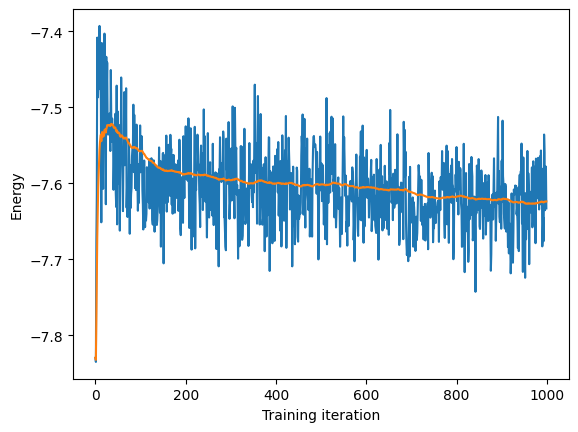

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(energy[:,0,0])
plt.plot(pd.DataFrame(energy[:,0,0]).ewm(halflife=100).mean())
plt.xlabel('Training iteration')
plt.ylabel('Energy')
plt.show()